<a href="https://colab.research.google.com/github/goutham-kaluvakolu/DL-MNIST/blob/main/Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def transform_with_noise(img):
    # Convert the PIL image to a tensor
    img = transforms.ToTensor()(img).squeeze(0)

    noise_amount = 0.2
    num_noise_pixels = int(28 * 28 * noise_amount)

    # Add salt noise (white pixels)
    noise_coordinates_x = np.random.randint(0, 28, size=(int(num_noise_pixels / 2)))
    noise_coordinates_y = np.random.randint(0, 28, size=(int(num_noise_pixels / 2)))
    img[noise_coordinates_x, noise_coordinates_y] = 1

    # Add pepper noise (black pixels)
    noise_coordinates_x = np.random.randint(0, 28, size=(int(num_noise_pixels / 2)))
    noise_coordinates_y = np.random.randint(0, 28, size=(int(num_noise_pixels / 2)))
    img[noise_coordinates_x, noise_coordinates_y] = 0

    return img.unsqueeze(0)


In [ ]:
transform_with_noise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(transform_with_noise)
])

In [31]:
train_dataset = torchvision.datasets.MNIST(root = "./data" , train = True , download = True ,  transform = transform_with_noise)
valid_dataset = torchvision.datasets.MNIST(root = "./data" , train = False , download = True ,  transform = transform_with_noise)
o_train_dataset = torchvision.datasets.MNIST(root = "./data" , train = True , download = True ,  transform = transforms.ToTensor())
o_valid_dataset = torchvision.datasets.MNIST(root = "./data" , train = False , download = True ,  transform =  transforms.ToTensor())

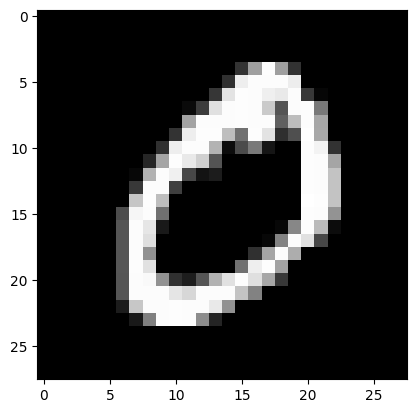

In [33]:
img=o_train_dataset[1][0]
plt.imshow(img.squeeze(0), cmap='gray')
plt.show()

In [48]:
train_dl = torch.utils.data.DataLoader(train_dataset , batch_size = 16)
val = torch.utils.data.DataLoader(valid_dataset , batch_size = 16)
o_train_dl = torch.utils.data.DataLoader(train_dataset , batch_size = 16)
o_val = torch.utils.data.DataLoader(valid_dataset , batch_size = 16)

In [49]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, latent_dimensions, data_shape):
        super(SimpleAutoencoder, self).__init__()
        self.latent_dimensions = latent_dimensions
        self.data_shape = data_shape

        # Encoder with dropout
        self.encoder = nn.Sequential(
            nn.Linear(784, 194),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(194, 97),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(97, latent_dimensions),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimensions, 97),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(97, 194),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(194, data_shape[0] * data_shape[1]),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)
        return decoded_data


In [51]:
latent_dimensions = 48
data_shape = (28, 28)
model = SimpleAutoencoder(latent_dimensions, data_shape)

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [53]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [54]:
train_loss = []
valid_loss = []

In [55]:
num_epochs = 100

In [56]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [57]:
for epoch in range(num_epochs):
  train_epoch_loss = 0
  dev_epoch_loss = 0
  for (imgs , _),(o_imgs,_) in zip(train_dl,o_train_dl):
    imgs = imgs.to(device)
    o_imgs = o_imgs.to(device)
    imgs = imgs.flatten(1)
    o_imgs = imgs.flatten(1)
    output = model(imgs)
    loss = loss_fn(output.view(-1,28*28), o_imgs)
    train_epoch_loss += loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  scheduler.step()
  print(f"epoch {epoch} loss {train_epoch_loss/len(train_dl)}")
  train_loss.append(train_epoch_loss/len(train_dl))
  with torch.no_grad():
    for (imgs , _),(o_imgs,_) in zip(val,o_val):
      imgs = imgs.to(device)
      o_imgs = o_imgs.to(device)
      imgs = imgs.flatten(1)
      o_imgs = imgs.flatten(1)
      output = model(imgs)
      loss = loss_fn(output.view(-1,28*28), o_imgs)
      dev_epoch_loss += loss.cpu().detach().numpy()
    print(f"dev loss {dev_epoch_loss/len(val)}")
    valid_loss.append(dev_epoch_loss/len(val))
torch.save(model.state_dict(), 'model_weights.pth')

epoch 0 loss 0.1136524832960385
dev loss 0.10330781093828238
epoch 1 loss 0.10020747419391106
dev loss 0.09886974063079068
epoch 2 loss 0.097344355621953
dev loss 0.09684391291278183
epoch 3 loss 0.09593761122144108
dev loss 0.09557898940554091
epoch 4 loss 0.09500122500031488
dev loss 0.09469947807348458
epoch 5 loss 0.0941068781956808
dev loss 0.09381444196981989
epoch 6 loss 0.0938732465272392
dev loss 0.09363285081971223
epoch 7 loss 0.09381951849216591
dev loss 0.09356788204164262
epoch 8 loss 0.0936611502457148
dev loss 0.09350910759086062
epoch 9 loss 0.09364439465248509
dev loss 0.09335781823677622
epoch 10 loss 0.0935667002124827
dev loss 0.09336486729277167
epoch 11 loss 0.09356163172865473
dev loss 0.09347696896571263


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

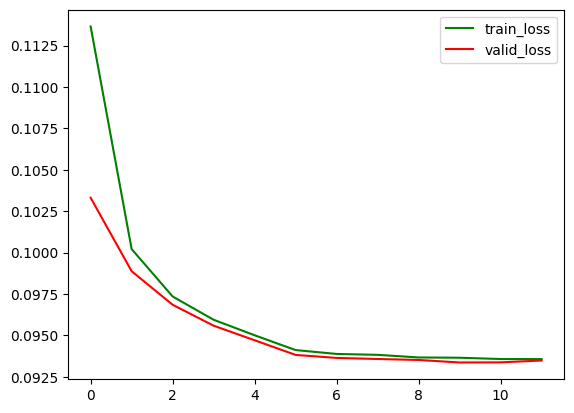

In [58]:
# prompt: #trainloss in green and vaild loss in red

import matplotlib.pyplot as plt

plt.plot(train_loss, color='green', label='train_loss')
plt.plot(valid_loss, color='red', label='valid_loss')
plt.legend()
plt.show()


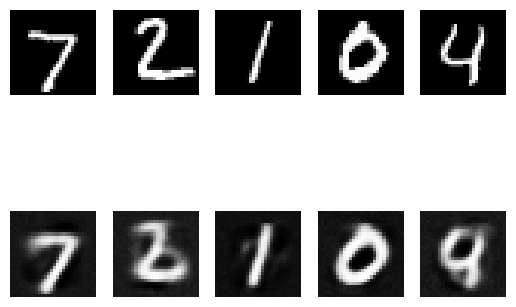

In [59]:
# prompt: take first 5 images from val and pass it to autoencoder and plt them side by side

import matplotlib.pyplot as plt

# Get the first 5 images from the validation set
images = valid_dataset.data[:5]
# images = train_dataset.data[:5]

images = images.to(device)
# images = images.flatten(1)
images =  images/255.0

# Get the labels for the first 5 images
# Pass the images through the autoencoder
encoded_images = model.encoder(images.view(-1, 784))
decoded_images = model.decoder(encoded_images)

# Plot the original and decoded images side by side
for i in range(5):
  plt.subplot(2, 5, i + 1)
  plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.subplot(2, 5, i + 6)
  plt.imshow(decoded_images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
  plt.axis('off')
plt.show()


In [ ]:
from torchsummary import summary
summary(model, (1, 28*28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 194]         152,290
              ReLU-2               [-1, 1, 194]               0
           Dropout-3               [-1, 1, 194]               0
            Linear-4                [-1, 1, 97]          18,915
              ReLU-5                [-1, 1, 97]               0
           Dropout-6                [-1, 1, 97]               0
            Linear-7                [-1, 1, 48]           4,704
            Linear-8                [-1, 1, 97]           4,753
           Dropout-9                [-1, 1, 97]               0
             ReLU-10                [-1, 1, 97]               0
           Linear-11               [-1, 1, 194]          19,012
             ReLU-12               [-1, 1, 194]               0
          Dropout-13               [-1, 1, 194]               0
           Linear-14               [-1,

In [ ]:
model.eval()

latent_vectors = []

with torch.no_grad():
  for imgs, _ in train_dl:
    imgs = imgs.to(device)
    imgs = imgs.flatten(1)
    latent_vectors.append(model.encoder(imgs))

# Concatenate the latent vectors into a single tensor
latent_vectors = torch.cat(latent_vectors, dim=0)

print(f"train dataset shape: {train_dataset.data.shape}, {60000 * 28 * 28}")
print(f"latent vectors shape: {latent_vectors.shape}, is {60000 * 48}")
print(f"img comressed: {28 * 28 / 48} times")

train dataset shape: torch.Size([60000, 28, 28]), 47040000
latent vectors shape: torch.Size([60000, 48]), is 2880000
img comressed: 16.333333333333332 times
